In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
    
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/blur-dataset/defocused_blurred/0_IPHONE-SE_F.JPG
/kaggle/input/blur-dataset/defocused_blurred/330_XIAOMI-PROCOFONE-F1_F.jpg
/kaggle/input/blur-dataset/defocused_blurred/46_IPHONE-8-PLUS_F.jpg
/kaggle/input/blur-dataset/defocused_blurred/121_HONOR-7X_F.jpg
/kaggle/input/blur-dataset/defocused_blurred/337_XIAOMI-PROCOFONE-F1_F.jpg
/kaggle/input/blur-dataset/defocused_blurred/43_HONOR-8X_F.jpg
/kaggle/input/blur-dataset/defocused_blurred/319_XIAOMI-REDMI-NOTE-4X_F.jpg
/kaggle/input/blur-dataset/defocused_blurred/123_NIKON-D3400-35MM_F.JPG
/kaggle/input/blur-dataset/defocused_blurred/306_XIAOMI-REDMI-5-PLUS_F.jpg
/kaggle/input/blur-dataset/defocused_blurred/33_HONOR-8X_F.jpg
/kaggle/input/blur-dataset/defocused_blurred/187_XIAOMI-REDMI-4A_F.jpg
/kaggle/input/blur-dataset/defocused_blurred/132_NIKON-D3400-18-55MM_F.JPG
/kaggle/input/blur-dataset/defocused_blurred/317_IPHONE-8-PLUS_F.jpg
/kaggle/input/blur-dataset/defocused_blurred/341_XIAOMI-PROCOFONE-F1_F.jpg
/kaggle/input/bl

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
import cv2
import pandas as pd

In [3]:
img=cv2.imread('/kaggle/input/blur-dataset/defocused_blurred/0_IPHONE-SE_M.JPG')

[ WARN:0@0.120] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/blur-dataset/defocused_blurred/0_IPHONE-SE_M.JPG'): can't open/read file: check file path/integrity


In [4]:
# t=0
# for img in os.listdir('/kaggle/input/blur-dataset/sharp'):
#     img = cv2.imread(os.path.join('/kaggle/input/blur-dataset/sharp',img))
#     if img.shape ==  (2048,1536,3):
#         t=t+1
    
# print(t)
        

In [5]:
transforms = v2.Compose([ v2.ToImage(),
                         v2.Resize((256,256)),
                          
                         v2.ToDtype(torch.float32, scale=True)
                        ])

In [6]:
from torch.utils.data import Dataset, DataLoader

In [7]:
img_names = {}
blur=[]
sharp=[]
for img in os.listdir('/kaggle/input/blur-dataset/motion_blurred'):
    blur.append(img)
for img in os.listdir('/kaggle/input/blur-dataset/sharp'):
    sharp.append(img)
blur.sort()
sharp.sort()
img_names['blur']=blur
img_names['sharp']=sharp


In [8]:
df=pd.DataFrame(img_names)

In [9]:
len(df)

350

In [10]:
class MyData(Dataset):
    def __init__(self,df,blur_path,sharpen_path,transform):
        self.df=df
        self.transform=transform
        self.bp=blur_path
        self.sp=sharpen_path
    def __len__(self):
        return len(self.df)
    def __getitem__(self,index):
        blur_image_path=os.path.join(self.bp,self.df['blur'][index])
        sharpen_image_path=os.path.join(self.sp,self.df['sharp'][index])
        bimg=cv2.imread(blur_image_path)
        simg=cv2.imread(sharpen_image_path)
        x = self.transform(bimg)
        y = self.transform(simg)
        return x,y
    

In [11]:
train_df=df[:245]
test_df=df[245:300]
valid_df=df[300:]

In [12]:
train_data = MyData(train_df,'/kaggle/input/blur-dataset/motion_blurred','/kaggle/input/blur-dataset/sharp',transforms)
test_data = MyData(test_df,'/kaggle/input/blur-dataset/motion_blurred','/kaggle/input/blur-dataset/sharp',transforms)
valid_data = MyData(valid_df,'/kaggle/input/blur-dataset/motion_blurred','/kaggle/input/blur-dataset/sharp',transforms)

In [13]:
train_loader = DataLoader(train_data,batch_size=1,shuffle=True)
valid_loader = DataLoader(valid_data,batch_size=1,shuffle=True)
test_loader = DataLoader(test_data,batch_size=1,shuffle=True)


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.conv_block1 = self.conv_block(3, 64)   
        self.conv_block2 = self.conv_block(64, 128)
        self.conv_block3 = self.conv_block(128, 256)
        self.conv_block4 = self.conv_block(256, 512)
        self.conv_block5 = self.conv_block(512,1024)
        
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(1024 * 8 * 8, 4096)
        self.relu1 = nn.ReLU(inplace=True)
        self.dense2 = nn.Linear(4096, 1024 * 8 * 8)
        self.relu2 = nn.ReLU(inplace=True)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(1024, 8, 8))

        self.up_conv1 = self.up_conv(1024, 512)
        self.up_conv2 = self.up_conv(512, 256)
        self.up_conv3 = self.up_conv(256, 128)
        self.up_conv4 = self.up_conv(128, 64)

        self.final_conv = nn.Conv2d(64, 3, kernel_size=3,padding='same').to(device)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True)
        ).to(device)

    def up_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
#             nn.ReLU(inplace=True)
        ).to(device)
    def pool(self, x):
        return nn.AvgPool2d(kernel_size=2, stride=2)(x).to(device)

    def forward(self, x):
 
        out1 = self.conv_block1(x)
        pool1 = self.pool(out1)   #64, 64, 64
        
        out2 = self.conv_block2(pool1)
        pool2 = self.pool(out2)  #128, 32,32
        
        
        out3 = self.conv_block3(pool2)
        pool3 = self.pool(out3)
        
        out4 = self.conv_block4(pool3)
        pool4 = self.pool(out4)  #512, 16,16

        out5 = self.conv_block5(pool4)  #1024,8,8
        
        
        up1 = self.up_conv1(out5)  #512,16,16
        up1 = self.crop_and_concat(out4, up1) #1024,16,16
        up1 = self.conv_block(1024, 512)(up1) #512,16,16

        up2 = self.up_conv2(out4)
        up2 = self.crop_and_concat(out3, up2)
        up2 = self.conv_block(512, 256)(up2)  #256,32,32


        up3 = self.up_conv3(up2)
        up3 = self.crop_and_concat(out2, up3)
        up3 = self.conv_block(256, 128)(up3)

        up4 = self.up_conv4(up3)
        up4 = self.crop_and_concat(out1, up4)
        up4 = self.conv_block(128, 64)(up4)  # 64,128,128

        return self.final_conv(up4)  #3,128,128
    

    def crop_and_concat(self, first, second):
#         _, _, H, W = upsampled.size()
#         bypass = self.center_crop(bypass, H, W)
        return torch.cat((first, second), dim=1)



In [16]:
q = iter(train_loader)

In [17]:
x,y=next(q)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [18]:
x.shape

torch.Size([1, 3, 256, 256])

In [19]:
y.shape

torch.Size([1, 3, 256, 256])

In [20]:
model=UNET()
l = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.005) 
total_step = len(train_loader)

In [21]:

model = model.to(device)

In [22]:
num_epochs=10
for epoch in range(num_epochs):
    for i, (b_img, s_img) in enumerate(train_loader):  
        optimizer.zero_grad()
        b_img, s_img = b_img.to(device, dtype=torch.float), s_img.to(device, dtype=torch.float)
        outputs = model(b_img)
        loss = l(outputs, s_img)
        
        
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/10], Loss: 0.0626
Epoch [2/10], Loss: 0.0601
Epoch [3/10], Loss: 0.0825
Epoch [4/10], Loss: 0.0611
Epoch [5/10], Loss: 0.0426
Epoch [6/10], Loss: 0.0603
Epoch [7/10], Loss: 0.0304
Epoch [8/10], Loss: 0.0572
Epoch [9/10], Loss: 0.0716
Epoch [10/10], Loss: 0.0837


In [23]:
torch.save(model, 'model.pth')


In [24]:
q = iter(test_loader)

In [25]:
q

In [26]:
w= iter(train_loader)

In [27]:
x,y=next(w)

In [28]:
x=x.to(device)

In [29]:
p=model(x)

In [30]:
p.shape


torch.Size([1, 3, 256, 256])

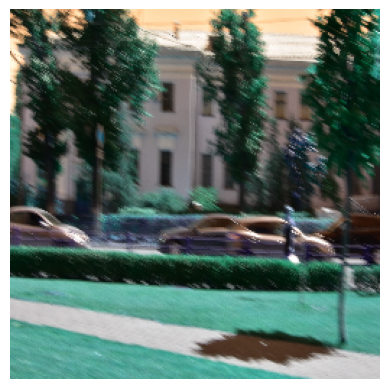

In [31]:
import torch
import matplotlib.pyplot as plt
import numpy as np
image_tensor =x  
image_tensor = image_tensor.squeeze(0)
image_tensor = image_tensor.detach().cpu()
image_np = image_tensor.numpy()
image_np = np.transpose(image_np, (1, 2, 0))
plt.imshow(image_np)
plt.axis('off')
plt.show()


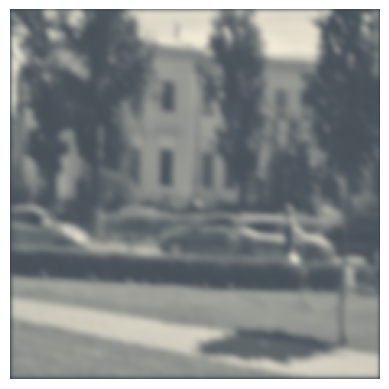

In [32]:
import torch
import matplotlib.pyplot as plt
import numpy as np
image_tensor =p  
image_tensor = image_tensor.squeeze(0)
image_tensor = image_tensor.detach().cpu()
image_np = image_tensor.numpy()
image_np = np.transpose(image_np, (1, 2, 0))
plt.imshow(image_np)
plt.axis('off')
plt.show()


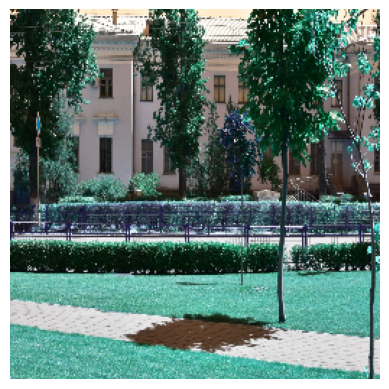

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np
image_tensor =y
image_tensor = image_tensor.squeeze(0)
image_tensor = image_tensor.detach().cpu()
image_np = image_tensor.numpy()
image_np = np.transpose(image_np, (1, 2, 0))
plt.imshow(image_np)
plt.axis('off')
plt.show()
